In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import holidays
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns

2025-07-01 17:18:54.579574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preparing the Datasets

In [2]:
train_df = pd.read_csv('../0_DataPreparation/Project_data/train.csv')
test_df = pd.read_csv('../0_DataPreparation/Project_data/test.csv')
weather_df = pd.read_csv('../0_DataPreparation/Project_data/wetter.csv')
kiwo_df = pd.read_csv('../0_DataPreparation/Project_data/kiwo.csv')

sample_df = pd.read_csv('../0_DataPreparation/Project_data/sample_submission.csv')

In [3]:
train_df = train_df.sort_values('Datum')
test_df = test_df.sort_values('Datum')

In [4]:
train_df

,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
3638,1307013,2013-07-01,3,201.198426
7223,1307015,2013-07-01,5,317.475875
1819,1307012,2013-07-01,2,535.856285
5457,1307014,2013-07-01,4,65.890169
...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313
1818,1807311,2018-07-31,1,123.075682
5456,1807313,2018-07-31,3,285.872616
3637,1807312,2018-07-31,2,586.081666


In [5]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


In [65]:
train_df['Datum'] = pd.to_datetime(train_df['Datum'], format='mixed', dayfirst=True, errors='coerce')
test_df['Datum'] = pd.to_datetime(test_df['Datum'], format='mixed', dayfirst=True, errors='coerce')

In [66]:
train_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
dtype: bool

In [6]:
test_df.isna().any()

id             False
Datum          False
Warengruppe    False
dtype: bool

In [7]:
train_df

,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
3638,1307013,2013-07-01,3,201.198426
7223,1307015,2013-07-01,5,317.475875
1819,1307012,2013-07-01,2,535.856285
5457,1307014,2013-07-01,4,65.890169
...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313
1818,1807311,2018-07-31,1,123.075682
5456,1807313,2018-07-31,3,285.872616
3637,1807312,2018-07-31,2,586.081666


In [69]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


# Visualizating the Datasets

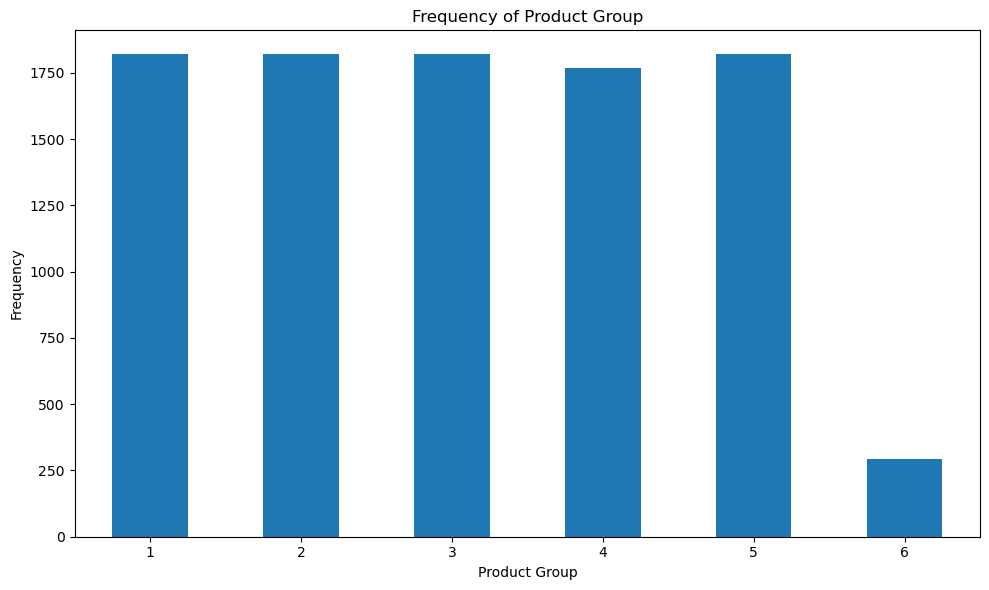

In [8]:
waren_gruppe_counts = train_df["Warengruppe"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
waren_gruppe_counts.plot(kind='bar')

plt.title('Frequency of Product Group')
plt.xlabel('Product Group')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

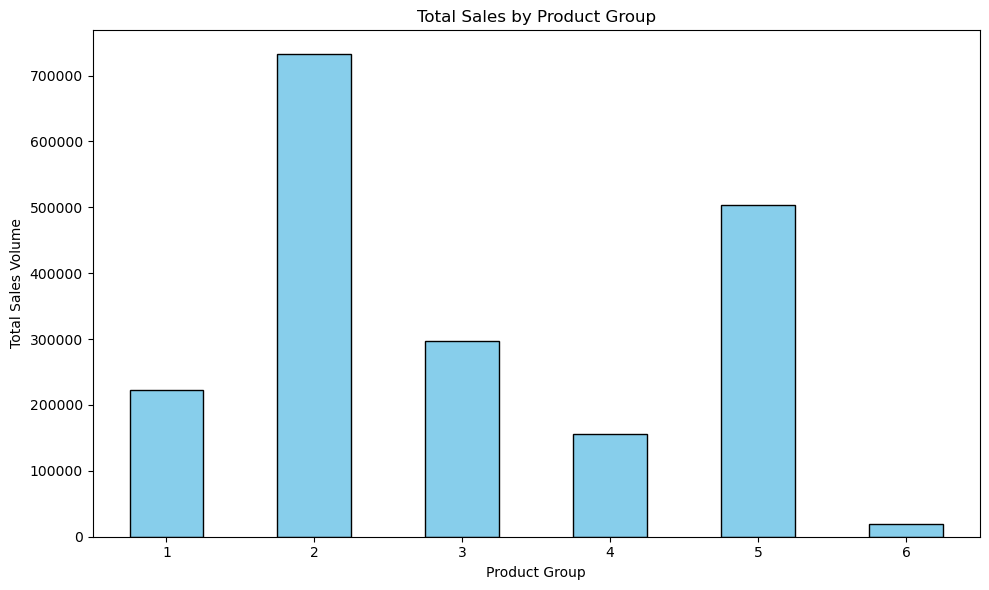

In [9]:
category_sales = train_df.groupby('Warengruppe')['Umsatz'].sum()
plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Product Group')
plt.xlabel('Product Group')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

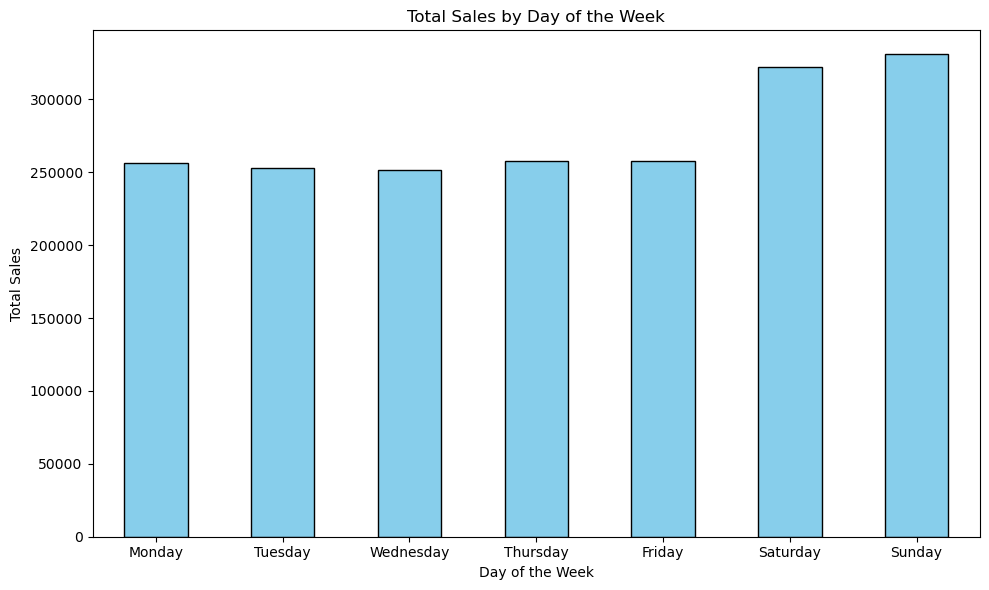

In [11]:
train_df['Datum'] = pd.to_datetime(train_df['Datum'])  
train_df['weekday'] = train_df['Datum'].dt.day_name()

weekday_sales = train_df.groupby('weekday')['Umsatz'].sum()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(ordered_days)

plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

In [13]:
merged_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')

In [14]:
merged_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
weekday        False
KielerWoche     True
dtype: bool

In [15]:
merged_df['KielerWoche'] = merged_df['KielerWoche'].fillna(0)

In [16]:
merged_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
weekday        False
KielerWoche    False
dtype: bool

In [17]:
merged_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,0.0
1,1307013,2013-07-01,3,201.198426,Monday,0.0
2,1307015,2013-07-01,5,317.475875,Monday,0.0
3,1307012,2013-07-01,2,535.856285,Monday,0.0
4,1307014,2013-07-01,4,65.890169,Monday,0.0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,0.0
9330,1807311,2018-07-31,1,123.075682,Tuesday,0.0
9331,1807313,2018-07-31,3,285.872616,Tuesday,0.0
9332,1807312,2018-07-31,2,586.081666,Tuesday,0.0


In [18]:
merged_df["KielerWoche"].value_counts()

KielerWoche
0.0    9111
1.0     223
Name: count, dtype: int64

In [19]:
merged_df = merged_df.sort_values('Datum').reset_index(drop=True)

merged_df['kw_block'] = (merged_df['KielerWoche'] != merged_df['KielerWoche'].shift(1)).cumsum()

kw_blocks = merged_df[merged_df['KielerWoche'] == 1].groupby('kw_block').agg(
    start_date=('Datum', 'min'),
    end_date=('Datum', 'max')
).reset_index(drop=True)

print(kw_blocks)

  start_date   end_date
0 2014-06-21 2014-06-29
1 2015-06-20 2015-06-28
2 2016-06-18 2016-06-26
3 2017-06-17 2017-06-25
4 2018-06-16 2018-06-24


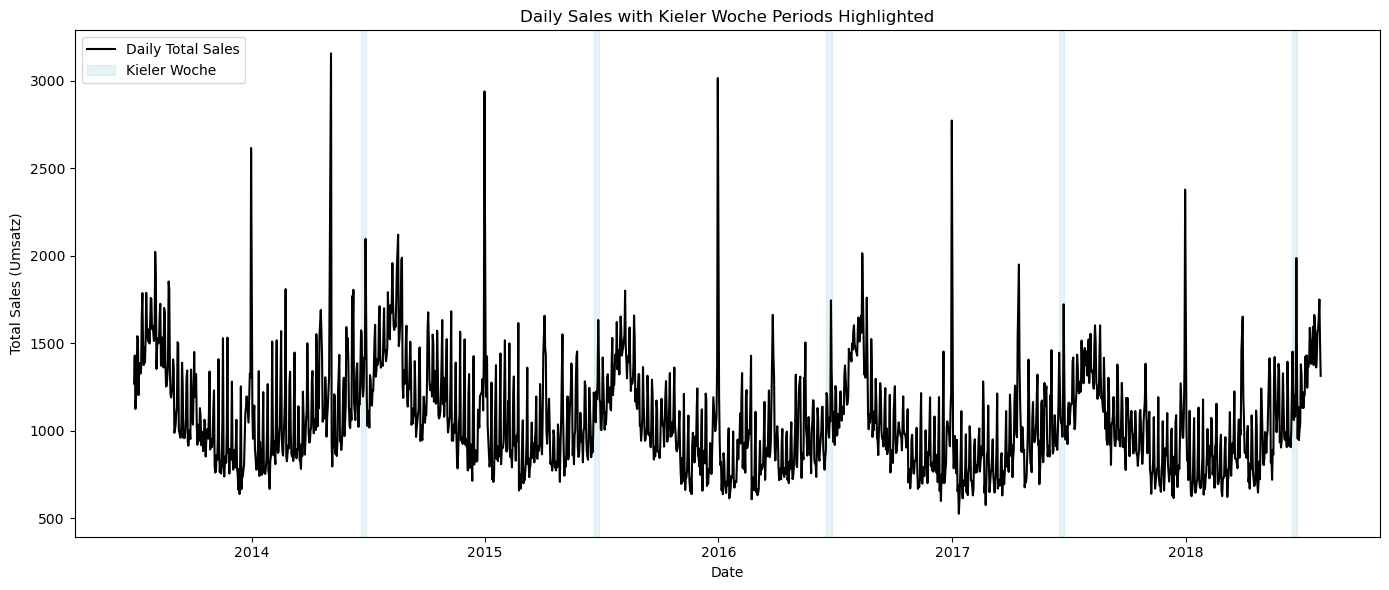

In [20]:
daily_sales = merged_df.groupby('Datum')['Umsatz'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Datum'], daily_sales['Umsatz'], label='Daily Total Sales', color='black')

for _, row in kw_blocks.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color='lightblue', alpha=0.3, label='Kieler Woche')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Date')
plt.ylabel('Total Sales (Umsatz)')
plt.title('Daily Sales with Kieler Woche Periods Highlighted')
plt.tight_layout()
plt.show()

# Feature Engineering

In [21]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday
0,1307011,2013-07-01,1,148.828353,Monday
3638,1307013,2013-07-01,3,201.198426,Monday
7223,1307015,2013-07-01,5,317.475875,Monday
1819,1307012,2013-07-01,2,535.856285,Monday
5457,1307014,2013-07-01,4,65.890169,Monday
...,...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313,Tuesday
1818,1807311,2018-07-31,1,123.075682,Tuesday
5456,1807313,2018-07-31,3,285.872616,Tuesday
3637,1807312,2018-07-31,2,586.081666,Tuesday


In [22]:
train_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')

In [23]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,NaN
1,1307013,2013-07-01,3,201.198426,Monday,NaN
2,1307015,2013-07-01,5,317.475875,Monday,NaN
3,1307012,2013-07-01,2,535.856285,Monday,NaN
4,1307014,2013-07-01,4,65.890169,Monday,NaN
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,NaN
9330,1807311,2018-07-31,1,123.075682,Tuesday,NaN
9331,1807313,2018-07-31,3,285.872616,Tuesday,NaN
9332,1807312,2018-07-31,2,586.081666,Tuesday,NaN


## Type of missing value imputation used: Replaced all NaN values in the merged_df with 0. (All dates where the KielerWoche is NaN will become 0)

In [24]:
train_df['KielerWoche'] = train_df['KielerWoche'].fillna(0).astype(int)

In [25]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,0
1,1307013,2013-07-01,3,201.198426,Monday,0
2,1307015,2013-07-01,5,317.475875,Monday,0
3,1307012,2013-07-01,2,535.856285,Monday,0
4,1307014,2013-07-01,4,65.890169,Monday,0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,0
9330,1807311,2018-07-31,1,123.075682,Tuesday,0
9331,1807313,2018-07-31,3,285.872616,Tuesday,0
9332,1807312,2018-07-31,2,586.081666,Tuesday,0


In [26]:
train_df['KielerWoche'].value_counts()

KielerWoche
0    9111
1     223
Name: count, dtype: int64

In [27]:
train_df['weekday'] = train_df['Datum'].dt.weekday  

In [28]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,0,0
1,1307013,2013-07-01,3,201.198426,0,0
2,1307015,2013-07-01,5,317.475875,0,0
3,1307012,2013-07-01,2,535.856285,0,0
4,1307014,2013-07-01,4,65.890169,0,0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0
9330,1807311,2018-07-31,1,123.075682,1,0
9331,1807313,2018-07-31,3,285.872616,1,0
9332,1807312,2018-07-31,2,586.081666,1,0


In [29]:
train_df['month'] = train_df['Datum'].dt.month

In [30]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche,month
0,1307011,2013-07-01,1,148.828353,0,0,7
1,1307013,2013-07-01,3,201.198426,0,0,7
2,1307015,2013-07-01,5,317.475875,0,0,7
3,1307012,2013-07-01,2,535.856285,0,0,7
4,1307014,2013-07-01,4,65.890169,0,0,7
...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0,7
9330,1807311,2018-07-31,1,123.075682,1,0,7
9331,1807313,2018-07-31,3,285.872616,1,0,7
9332,1807312,2018-07-31,2,586.081666,1,0,7


In [31]:
train_df['is_weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

In [32]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche,month,is_weekend
0,1307011,2013-07-01,1,148.828353,0,0,7,0
1,1307013,2013-07-01,3,201.198426,0,0,7,0
2,1307015,2013-07-01,5,317.475875,0,0,7,0
3,1307012,2013-07-01,2,535.856285,0,0,7,0
4,1307014,2013-07-01,4,65.890169,0,0,7,0
...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0,7,0
9330,1807311,2018-07-31,1,123.075682,1,0,7,0
9331,1807313,2018-07-31,3,285.872616,1,0,7,0
9332,1807312,2018-07-31,2,586.081666,1,0,7,0


In [34]:
dummies = pd.get_dummies(train_df['Warengruppe'], prefix='Warengruppe', drop_first=False).astype(int)

In [35]:
dummies

,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,1,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
9329,0,0,0,0,1,0
9330,1,0,0,0,0,0
9331,0,0,1,0,0,0
9332,0,1,0,0,0,0


In [36]:
train_df = pd.concat([train_df.drop(columns=['Warengruppe']), dummies], axis=1)

In [37]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0


In [38]:
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['weekday'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['weekday'] / 7)

In [39]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0,0.000000,1.00000
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0,0.000000,1.00000
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0,0.000000,1.00000
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0,0.000000,1.00000
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0,0.781831,0.62349
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0,0.781831,0.62349
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0,0.781831,0.62349
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0,0.781831,0.62349


In [42]:
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)

In [43]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025


In [44]:
train_df = train_df.drop(columns=['weekday', 'month'])

In [45]:
train_df

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025
9330,1807311,2018-07-31,123.075682,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025
9331,1807313,2018-07-31,285.872616,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025
9332,1807312,2018-07-31,586.081666,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025


In [46]:
german_holidays = holidays.Germany(prov='SH', years=range(2012, 2020))

holiday_dates = set(german_holidays.keys())

In [48]:
train_df['is_holiday'] = train_df['Datum'].isin(holiday_dates).astype(int)

/var/folders/0v/wz051f795j13ts216fq3zpwc0000gn/T/ipykernel_24109/1142137448.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_df['is_holiday'] = train_df['Datum'].isin(holiday_dates).astype(int)


In [49]:
train_df

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_holiday
0,1307011,2013-07-01,148.828353,0,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
1,1307013,2013-07-01,201.198426,0,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
2,1307015,2013-07-01,317.475875,0,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025,0
3,1307012,2013-07-01,535.856285,0,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
4,1307014,2013-07-01,65.890169,0,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025,0
9330,1807311,2018-07-31,123.075682,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9331,1807313,2018-07-31,285.872616,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9332,1807312,2018-07-31,586.081666,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0


In [50]:
train_df.columns

Index(['id', 'Datum', 'Umsatz', 'KielerWoche', 'is_weekend', 'Warengruppe_1',
       'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5',
       'Warengruppe_6', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
       'is_holiday'],
      dtype='object')

## Bar Charts with confidence intervals for two self-created variables

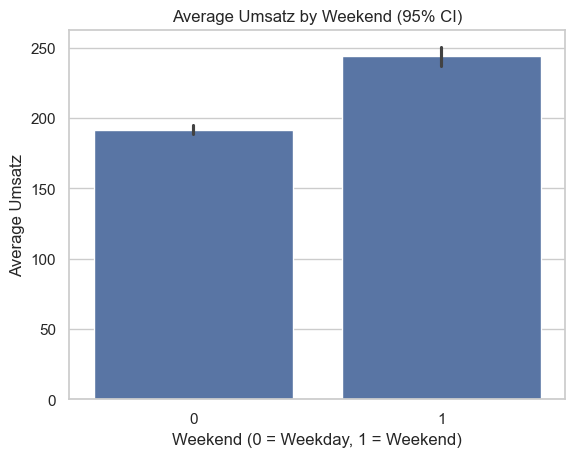

In [51]:
sns.set(style="whitegrid")
sns.barplot(data=train_df, x="is_weekend", y="Umsatz", errorbar=('ci', 95))
plt.title("Average Umsatz by Weekend (95% CI)")
plt.xlabel("Weekend (0 = Weekday, 1 = Weekend)")
plt.ylabel("Average Umsatz")
plt.show()

/var/folders/0v/wz051f795j13ts216fq3zpwc0000gn/T/ipykernel_24109/285058313.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df, x="KielerWoche", y="Umsatz", errorbar=('ci', 95), palette="Blues")


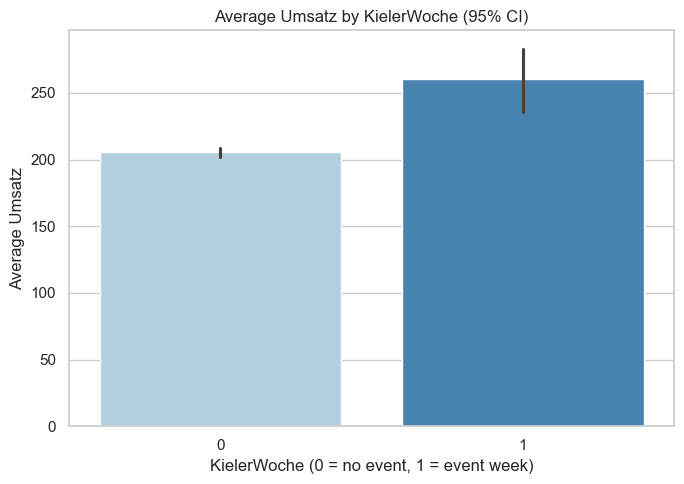

In [52]:
plt.figure(figsize=(7, 5))
sns.barplot(data=train_df, x="KielerWoche", y="Umsatz", errorbar=('ci', 95), palette="Blues")
plt.title("Average Umsatz by KielerWoche (95% CI)")
plt.xlabel("KielerWoche (0 = no event, 1 = event week)")
plt.ylabel("Average Umsatz")
plt.tight_layout()
plt.show()

/var/folders/0v/wz051f795j13ts216fq3zpwc0000gn/T/ipykernel_24109/1433026362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df, x="is_holiday", y="Umsatz", errorbar=('ci', 95), palette="Greens")


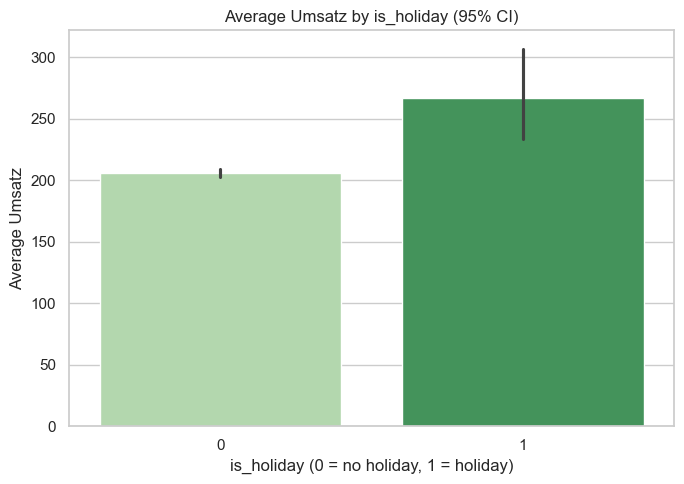

In [53]:
plt.figure(figsize=(7, 5))
sns.barplot(data=train_df, x="is_holiday", y="Umsatz", errorbar=('ci', 95), palette="Greens")
plt.title("Average Umsatz by is_holiday (95% CI)")
plt.xlabel("is_holiday (0 = no holiday, 1 = holiday)")
plt.ylabel("Average Umsatz")
plt.tight_layout()
plt.show()

In [54]:
train_df['is_off'] = ((train_df['is_weekend'] == 1) | (train_df['is_holiday'] == 1)).astype(int)

In [55]:
train_df = train_df.drop(columns=['is_weekend', 'is_holiday'])

In [56]:
train_df

,id,Datum,Umsatz,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,1307011,2013-07-01,148.828353,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
1,1307013,2013-07-01,201.198426,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
2,1307015,2013-07-01,317.475875,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025,0
3,1307012,2013-07-01,535.856285,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
4,1307014,2013-07-01,65.890169,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025,0
9330,1807311,2018-07-31,123.075682,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9331,1807313,2018-07-31,285.872616,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9332,1807312,2018-07-31,586.081666,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0


# Splitting the Datasets 

In [60]:
# Split Training set from 01.07.2013 to 31.07.2017
training_start_date = '2013-07-01'
training_end_date = '2017-07-31'
# Split Validation set from 01.08.2017 to 31.07.2018
validation_start_date = '2017-08-01'
validation_end_date = '2018-07-31'

In [61]:
df_train_split = train_df[(train_df['Datum'] >= training_start_date) & (train_df['Datum'] <= training_end_date)].copy()

In [62]:
df_train_split

,id,Datum,Umsatz,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,1307011,2013-07-01,148.828353,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025,0
1,1307013,2013-07-01,201.198426,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025,0
2,1307015,2013-07-01,317.475875,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025,0
3,1307012,2013-07-01,535.856285,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025,0
4,1307014,2013-07-01,65.890169,0,0,0,0,1,0,0,0.0,1.0,-0.5,-0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,1707311,2017-07-31,162.425333,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025,0
7489,1707313,2017-07-31,294.721801,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025,0
7490,1707315,2017-07-31,222.684256,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025,0
7491,1707312,2017-07-31,548.102447,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025,0


In [63]:
df_validation_split = train_df[(train_df['Datum'] >= validation_start_date) & (train_df['Datum'] <= validation_end_date)].copy()

In [64]:
df_validation_split

,id,Datum,Umsatz,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
7493,1708013,2017-08-01,294.872701,0,0,0,1,0,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7494,1708012,2017-08-01,557.470898,0,0,1,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7495,1708011,2017-08-01,166.135486,0,1,0,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7496,1708014,2017-08-01,88.208006,0,0,0,0,1,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7497,1708015,2017-08-01,325.864228,0,0,0,0,0,1,0,0.781831,0.62349,-0.866025,-0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,1,0,0.781831,0.62349,-0.500000,-0.866025,0
9330,1807311,2018-07-31,123.075682,0,1,0,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025,0
9331,1807313,2018-07-31,285.872616,0,0,0,1,0,0,0,0.781831,0.62349,-0.500000,-0.866025,0
9332,1807312,2018-07-31,586.081666,0,0,1,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025,0


In [65]:
X_train = df_train_split.drop(columns=['id', 'Datum', 'Umsatz'])

In [66]:
X_train

,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025,0
1,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025,0
2,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025,0
3,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025,0
4,0,0,0,0,1,0,0,0.0,1.0,-0.5,-0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7488,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025,0
7489,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025,0
7490,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025,0
7491,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025,0


In [67]:
Y_train = df_train_split['Umsatz']

In [68]:
Y_train

0       148.828353
1       201.198426
2       317.475875
3       535.856285
4        65.890169
           ...    
7488    162.425333
7489    294.721801
7490    222.684256
7491    548.102447
7492     87.226479
Name: Umsatz, Length: 7493, dtype: float64

# Base Modeling for the Datasets

Linear model optimization: model equation and adjusted R^2 

In [69]:
model = LinearRegression()

In [70]:
model.fit(X_train, Y_train)

LinearRegression()

In [71]:
coefficients = pd.Series(model.coef_, index=X_train.columns)
most_influential = coefficients.abs().sort_values(ascending=False)
print(most_influential)

Warengruppe_2    217.831037
Warengruppe_4    104.488497
Warengruppe_6    101.421007
Warengruppe_5     88.126678
Warengruppe_1     71.427925
is_off            50.944983
month_cos         32.739142
Warengruppe_3     28.620286
month_sin         28.086884
KielerWoche        6.224137
weekday_sin        3.243375
weekday_cos        0.886550
dtype: float64


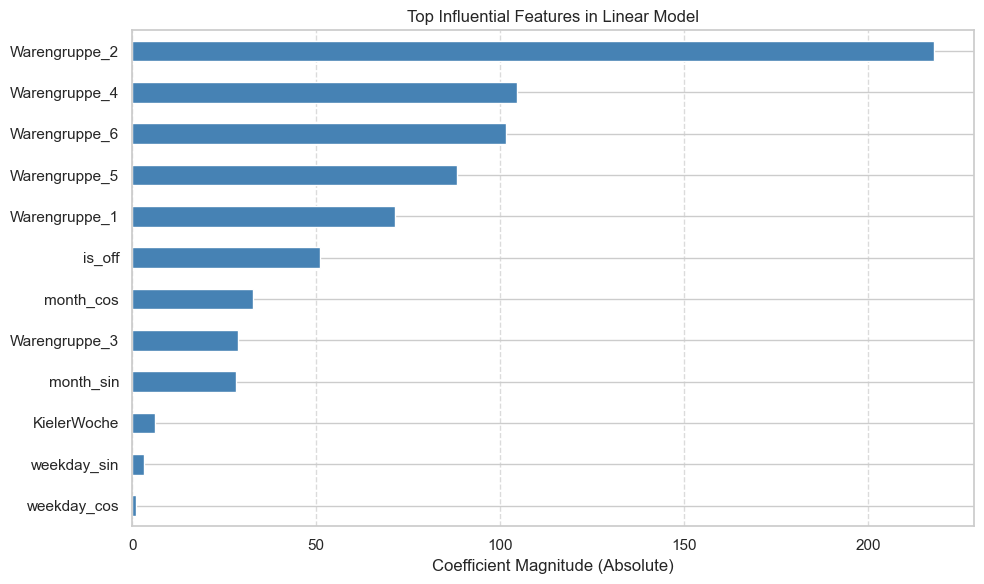

In [72]:
# Compute coefficients
coefficients = pd.Series(model.coef_, index=X_train.columns)
most_influential = coefficients.abs().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
most_influential.head(20).plot(kind='barh', color='steelblue')  # top 20 by absolute value
plt.gca().invert_yaxis()  # largest on top
plt.xlabel('Coefficient Magnitude (Absolute)')
plt.title('Top Influential Features in Linear Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [74]:
#Model Equation
equation = "Umsatz = {:.2f}".format(model.intercept_)
for feature, coef in zip(X_train.columns, model.coef_):
    equation += " + {:.2f} * {}".format(coef, feature) 
print(equation) 

Umsatz = 176.30 + 6.22 * KielerWoche + -71.43 * Warengruppe_1 + 217.83 * Warengruppe_2 + -28.62 * Warengruppe_3 + -104.49 * Warengruppe_4 + 88.13 * Warengruppe_5 + -101.42 * Warengruppe_6 + -3.24 * weekday_sin + -0.89 * weekday_cos + -28.09 * month_sin + -32.74 * month_cos + 50.94 * is_off


In [109]:
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1767.
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        19:37:10   Log-Likelihood:                -43267.
No. Observations:                7493   AIC:                         8.656e+04
Df Residuals:                    7481   BIC:                         8.664e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           151.1136      1.299    116.305

In [78]:
import statsmodels.api as sm

# Add constant term for intercept
X_train_sm = sm.add_constant(X_train)

# Fit OLS model
model = sm.OLS(Y_train, X_train_sm).fit()

# Now you can access:
print("R²:", model.rsquared)
print("Adjusted R²:", model.rsquared_adj)
print("Coefficients:")
print(model.params)

R²: 0.722087923572818
Adjusted R²: 0.7216792839737405
Coefficients:
const            151.113566
KielerWoche        6.224137
Warengruppe_1    -46.242330
Warengruppe_2    243.016631
Warengruppe_3     -3.434692
Warengruppe_4    -79.302902
Warengruppe_5    113.312272
Warengruppe_6    -76.235413
weekday_sin       -3.243375
weekday_cos       -0.886550
month_sin        -28.086884
month_cos        -32.739142
is_off            50.944983
dtype: float64


<Axes: >

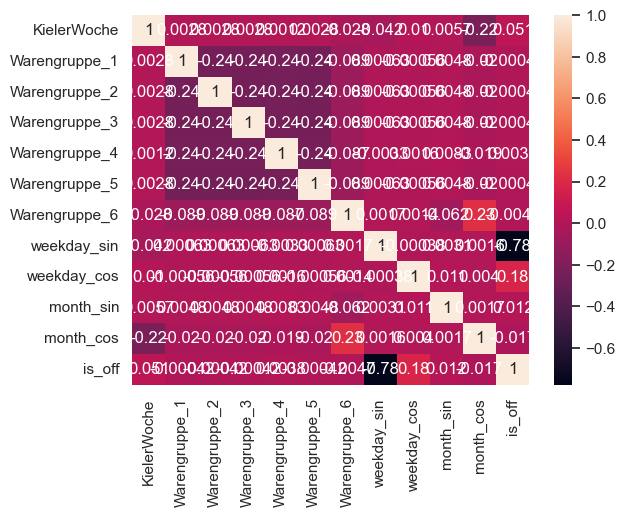

In [110]:
sns.heatmap(X_train.corr(), annot=True)


In [80]:
X_val = df_validation_split.drop(columns=['id', 'Datum', 'Umsatz'])

In [81]:
X_val

,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
7493,0,0,0,1,0,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7494,0,0,1,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7495,0,1,0,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7496,0,0,0,0,1,0,0,0.781831,0.62349,-0.866025,-0.500000,0
7497,0,0,0,0,0,1,0,0.781831,0.62349,-0.866025,-0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9329,0,0,0,0,0,1,0,0.781831,0.62349,-0.500000,-0.866025,0
9330,0,1,0,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025,0
9331,0,0,0,1,0,0,0,0.781831,0.62349,-0.500000,-0.866025,0
9332,0,0,1,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025,0


In [82]:
Y_val = df_validation_split['Umsatz']

In [83]:
Y_val

7493    294.872701
7494    557.470898
7495    166.135486
7496     88.208006
7497    325.864228
           ...    
9329    261.341313
9330    123.075682
9331    285.872616
9332    586.081666
9333     57.102795
Name: Umsatz, Length: 1841, dtype: float64

In [85]:
X_val_sm = sm.add_constant(X_val)
y_pred_val = model.predict(X_val_sm)


In [89]:
mape = mean_absolute_percentage_error(Y_val, y_pred_val)
print(f"Validation MAPE: {mape:.2f}")



Validation MAPE: 0.33


In [90]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


In [92]:
test_df['Datum'] = pd.to_datetime(test_df['Datum'])
test_df['weekday'] = test_df['Datum'].dt.day_name()


In [93]:
test_df

,id,Datum,Warengruppe,weekday
0,1808011,2018-08-01,1,Wednesday
710,1808013,2018-08-01,3,Wednesday
1065,1808014,2018-08-01,4,Wednesday
1419,1808015,2018-08-01,5,Wednesday
355,1808012,2018-08-01,2,Wednesday
...,...,...,...,...
354,1907301,2019-07-30,1,Tuesday
709,1907302,2019-07-30,2,Tuesday
1773,1907305,2019-07-30,5,Tuesday
1418,1907304,2019-07-30,4,Tuesday


In [94]:
test_df['weekday'] = test_df['Datum'].dt.weekday  

In [95]:
test_df['is_weekend'] = test_df['weekday'].isin([5, 6]).astype(int)

In [96]:
test_df['Datum'] = pd.to_datetime(test_df['Datum'])

In [97]:
merged_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

In [98]:
merged_df['KielerWoche'] = merged_df['KielerWoche'].fillna(0)

In [99]:
merged_df = merged_df.sort_values('Datum').reset_index(drop=True)

In [100]:
test_df['weekday'] = test_df['Datum'].dt.weekday
test_df['month'] = test_df['Datum'].dt.month

In [101]:
test_df['weekday_sin'] = np.sin(2 * np.pi * test_df['weekday'] / 7)
test_df['weekday_cos'] = np.cos(2 * np.pi * test_df['weekday'] / 7)

In [102]:
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)

In [103]:
test_df['is_holiday'] = test_df['Datum'].isin(holiday_dates).astype(int)

/var/folders/0v/wz051f795j13ts216fq3zpwc0000gn/T/ipykernel_24109/3785794079.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_df['is_holiday'] = test_df['Datum'].isin(holiday_dates).astype(int)


In [104]:
test_df['is_off'] = ((test_df['is_weekend'] == 1) | (test_df['is_holiday'] == 1)).astype(int)

In [105]:
test_df

,id,Datum,Warengruppe,weekday,is_weekend,month,weekday_sin,weekday_cos,month_sin,month_cos,is_holiday,is_off
0,1808011,2018-08-01,1,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
710,1808013,2018-08-01,3,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
1065,1808014,2018-08-01,4,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
1419,1808015,2018-08-01,5,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
355,1808012,2018-08-01,2,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354,1907301,2019-07-30,1,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0
709,1907302,2019-07-30,2,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0
1773,1907305,2019-07-30,5,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0
1418,1907304,2019-07-30,4,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0


In [106]:
warengruppe_dummies = pd.get_dummies(test_df['Warengruppe'], prefix='Warengruppe', drop_first=False).astype(int)

In [107]:
test_df = pd.concat([test_df.drop(columns=['Warengruppe', 'weekday', 'month']), warengruppe_dummies], axis=1)

In [108]:
test_df = test_df.drop(columns=['is_weekend', 'is_holiday'])

In [111]:
test_df

,id,Datum,weekday_sin,weekday_cos,month_sin,month_cos,is_off,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1808011,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0
710,1808013,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0
1065,1808014,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0
1419,1808015,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,0,1,0
355,1808012,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1907301,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0
709,1907302,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,1,0,0,0,0
1773,1907305,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,0,1,0
1418,1907304,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0


In [112]:
test_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

In [113]:
test_df['KielerWoche'] = test_df['KielerWoche'].fillna(0).astype(int)

In [114]:
test_df

,id,Datum,weekday_sin,weekday_cos,month_sin,month_cos,is_off,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,KielerWoche
0,1808011,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0,0
1,1808013,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0,0
2,1808014,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0,0
3,1808015,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,0,1,0,0
4,1808012,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,1907301,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0,0
1826,1907302,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,1,0,0,0,0,0
1827,1907305,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,0,1,0,0
1828,1907304,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0,0


In [115]:
test_df.isna().any()

id               False
Datum            False
weekday_sin      False
weekday_cos      False
month_sin        False
month_cos        False
is_off           False
Warengruppe_1    False
Warengruppe_2    False
Warengruppe_3    False
Warengruppe_4    False
Warengruppe_5    False
Warengruppe_6    False
KielerWoche      False
dtype: bool

In [116]:
test_id = test_df['id']

In [117]:
test_id

0       1808011
1       1808013
2       1808014
3       1808015
4       1808012
         ...   
1825    1907301
1826    1907302
1827    1907305
1828    1907304
1829    1907303
Name: id, Length: 1830, dtype: int64

In [118]:
test_df = test_df.drop(columns=['id','Datum'])

In [119]:
test_df

,weekday_sin,weekday_cos,month_sin,month_cos,is_off,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,KielerWoche
0,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0,0
1,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0,0
2,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0,0
3,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,0,1,0,0
4,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0,0
1826,0.781831,0.623490,-0.500000,-0.866025,0,0,1,0,0,0,0,0
1827,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,0,1,0,0
1828,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0,0


In [120]:
desired_order = ['KielerWoche', 'Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3',
       'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'is_off']

test_df = test_df.reindex(columns=desired_order, fill_value=0)

In [121]:
test_df

,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,0,1,0,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
1,0,0,0,1,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
2,0,0,0,0,1,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
3,0,0,0,0,0,1,0,0.974928,-0.222521,-0.866025,-0.500000,0
4,0,0,1,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0,1,0,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,0
1826,0,0,1,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,0
1827,0,0,0,0,0,1,0,0.781831,0.623490,-0.500000,-0.866025,0
1828,0,0,0,0,1,0,0,0.781831,0.623490,-0.500000,-0.866025,0


In [124]:
test_df_sm = sm.add_constant(test_df)
test_predictions = model.predict(test_df_sm)


In [125]:
test_predictions 

0       142.599981
1       185.407619
2       109.539409
3       302.154583
4       431.858942
           ...    
1825    144.179078
1826    433.438040
1827    303.733681
1828    111.118506
1829    186.986717
Length: 1830, dtype: float64

In [126]:
#merge test_id with test_predictions to form baseline_model_submission
baseline_model_submission = pd.DataFrame({'id': test_id, 'umsatz': test_predictions})

In [127]:
baseline_model_submission

,id,umsatz
0,1808011,142.599981
1,1808013,185.407619
2,1808014,109.539409
3,1808015,302.154583
4,1808012,431.858942
...,...,...
1825,1907301,144.179078
1826,1907302,433.438040
1827,1907305,303.733681
1828,1907304,111.118506


In [128]:
test_df

,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,0,1,0,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
1,0,0,0,1,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
2,0,0,0,0,1,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
3,0,0,0,0,0,1,0,0.974928,-0.222521,-0.866025,-0.500000,0
4,0,0,1,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0,1,0,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,0
1826,0,0,1,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,0
1827,0,0,0,0,0,1,0,0.781831,0.623490,-0.500000,-0.866025,0
1828,0,0,0,0,1,0,0,0.781831,0.623490,-0.500000,-0.866025,0


# Neural Network

In [129]:
X_train_cnn = X_train.astype('float32').values
X_val_cnn = X_val.astype('float32').values

Y_train_cnn = Y_train.astype('float32').values
Y_val_cnn = Y_val.astype('float32').values

In [130]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(12,), name='dense_1'),
    Dropout(0.3),
    Dense(32, activation='relu', name='dense_2'),
    Dropout(0.2),
    Dense(1, activation='linear', name='output') ]
)


model.compile(
    optimizer='adam',
    loss='mape',
    metrics=['mape']
)


model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
history = model.fit(
    X_train_cnn,
    Y_train_cnn,
    validation_data=(X_val_cnn, Y_val_cnn),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 92.7071 - mape: 92.7071 - val_loss: 43.0893 - val_mape: 43.0893
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 43.3775 - mape: 43.3775 - val_loss: 28.3944 - val_mape: 28.3944
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.8796 - mape: 30.8796 - val_loss: 24.3393 - val_mape: 24.3393
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27.3010 - mape: 27.3010 - val_loss: 23.8343 - val_mape: 23.8343
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.0802 - mape: 27.0802 - val_loss: 23.1895 - val_mape: 23.1895
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.2901 - mape: 26.2901 - val_loss: 22.7352 - val_mape: 22.7352
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.0222 - mape: 26.0222 - val_loss: 22.5511 - val_mape: 22.5511
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.7399 - mape: 25.7399 - val_loss: 22.5702 - val_mape: 22.5702
Epoch 9/

In [132]:
y_pred_cnn = model.predict(X_val_cnn)

mape = mean_absolute_percentage_error(Y_val_cnn, y_pred_cnn)

print(f"Validation MAPE: {mape:.2f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation MAPE: 0.19


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Create a DataFrame with predictions and true values
val_results = pd.DataFrame({
    'y_true': Y_val_cnn.flatten(),
    'y_pred': y_pred_cnn.flatten()
})

# Define product group one-hot columns
one_hot_cols = [
    'Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3',
    'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6'
]

# Add one-hot encoded product group columns from df_validation_split
val_results[one_hot_cols] = df_validation_split[one_hot_cols].reset_index(drop=True)

# Decode the one-hot to actual product group
val_results['product_group'] = val_results[one_hot_cols].idxmax(axis=1)

# Clean up group names (remove '#', if present)
val_results['product_group'] = val_results['product_group'].str.replace('#', '', regex=False)

# Compute MAPE per product group
mape_per_group = val_results.groupby('product_group', group_keys=False).apply(
    lambda g: mean_absolute_percentage_error(g['y_true'], g['y_pred'])
)


#  Display result
print("Validation MAPE per Product Group:")
print(mape_per_group)

Validation MAPE per Product Group:
product_group
Warengruppe_1    0.195878
Warengruppe_2    0.164488
Warengruppe_3    0.194171
Warengruppe_4    0.215767
Warengruppe_5    0.148250
Warengruppe_6    0.476020
dtype: float64


/var/folders/0v/wz051f795j13ts216fq3zpwc0000gn/T/ipykernel_24109/371862356.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_per_group = val_results.groupby('product_group', group_keys=False).apply(


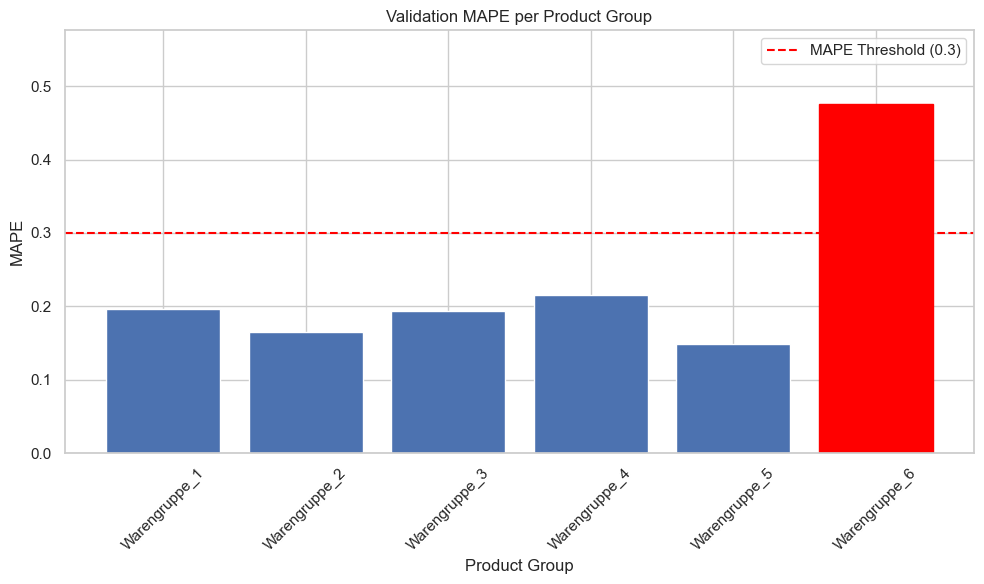

In [144]:


# Sample MAPE values (replace with your actual output if needed)
mape_per_group = pd.Series({
    'Warengruppe_1': 0.195878,
    'Warengruppe_2': 0.164488,
    'Warengruppe_3': 0.194171,
    'Warengruppe_4': 0.215767,
    'Warengruppe_5': 0.148250,
    'Warengruppe_6': 0.476020
})

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(mape_per_group.index, mape_per_group.values)
plt.axhline(0.3, color='red', linestyle='--', label='MAPE Threshold (0.3)')

# Highlight bars with high MAPE
for bar, val in zip(bars, mape_per_group.values):
    if val > 0.3:
        bar.set_color('red')

# Labels and formatting
plt.title('Validation MAPE per Product Group')
plt.ylabel('MAPE')
plt.xlabel('Product Group')
plt.xticks(rotation=45)
plt.ylim(0, max(mape_per_group.values) + 0.1)
plt.legend()
plt.tight_layout()
plt.show()


In [146]:
# Count how many rows belong to each Warengruppe in the full dataset
group_counts = df_train_split[['Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3',
                               'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6']].sum()
print("Sample count per product group:")
print(group_counts)


Sample count per product group:
Warengruppe_1    1462
Warengruppe_2    1462
Warengruppe_3    1462
Warengruppe_4    1409
Warengruppe_5    1462
Warengruppe_6     236
dtype: int64


In [162]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Flatten if needed (especially if arrays are 2D like (1841, 1))
y_true = Y_val_cnn.flatten()
y_pred = y_pred_cnn.flatten()

# Calculate regression metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Display results
print(f"Validation Performance Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Validation Performance Metrics:
MAE (Mean Absolute Error): 35.22
RMSE (Root Mean Squared Error): 56.86
R² Score: 0.8089


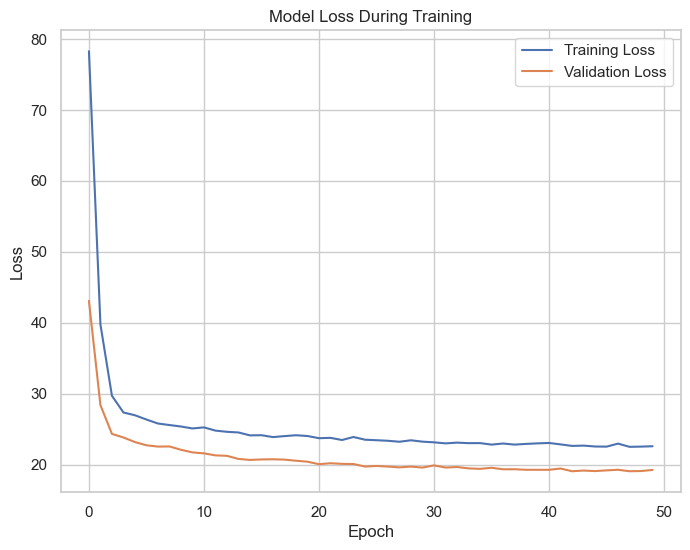

In [163]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()